Import des libraries

In [36]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings




warnings.filterwarnings("ignore")

Definition des fonctions BS et de Newton-Raphson pour calculer la vol implicite (memes fcts que le td precedant)

In [37]:
def black_scholes_call_price_for_IM(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(price, S, K, T, r, tol=1e-5, max_iter=1000):
    lower_bound = 0.0001
    upper_bound = 5.0
    iteration = 0

    while iteration < max_iter:
        mid = (lower_bound + upper_bound) / 2
        mid_price = black_scholes_call_price_for_IM(S, K, T, r, mid)

        if abs(mid_price - price) < tol:
            return mid
        elif mid_price < price:
            lower_bound = mid
        else:
            upper_bound = mid

        iteration += 1

    return mid

Definition des données et calcule des vols 

In [38]:
strike = np.array([95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
prices = np.array([10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46])
S = 100
rf = 0.002
T = 1

implied_vols = []
for K, price in zip(strike, prices):
    vol = implied_volatility(price, S, K, T, rf)
    implied_vols.append(vol)

results = pd.DataFrame({"Strike": strike, "Option Price": prices, "Implied Volatility": implied_vols})
print(results)

   Strike  Option Price  Implied Volatility
0      95         10.93            0.208123
1      96          9.55            0.186236
2      97          8.28            0.167306
3      98          7.40            0.158340
4      99          6.86            0.157592
5     100          6.58            0.162762
6     101          6.52            0.172779
7     102          6.49            0.182937
8     103          6.47            0.192824
9     104          6.46            0.202512


interpolation et plot des courbes (prix en fct du strike et vol en fct du strike) (peut etre refaire la courbe lissée car pas folle)

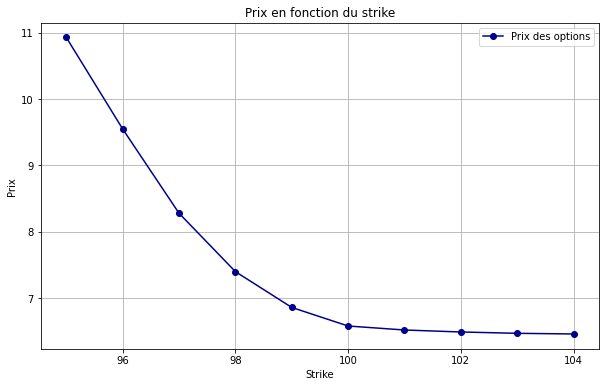

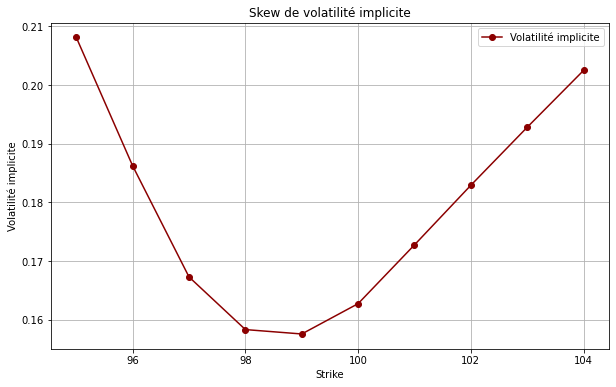

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(strike, prices, 'o', linestyle='-', color='darkblue', label='Prix des options')
plt.title('Prix en fonction du strike')
plt.xlabel('Strike')
plt.ylabel('Prix')
plt.grid()
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(strike, implied_vols, 'o', linestyle='-',color='darkred', label='Volatilité implicite')
plt.title('Skew de volatilité implicite')
plt.xlabel('Strike')
plt.ylabel('Volatilité implicite')
plt.grid()
plt.legend()

plt.show()

Definition du model SVI, de la methode de nelder mead et de la cost function

In [40]:
def svi_model(x, a, b, rho, m, sigma):
    return a + b * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))

def cost_function_1(params, x_data, y_data):
    a, b, rho, m, sigma = params
    y_pred = svi_model(x_data, a, b, rho, m, sigma)
    return np.sum((y_data - y_pred)**2)

def nelder_mead(initial_params, cost_function, x_data, y_data, tol=1e-6, max_iter=1000):
    n = len(initial_params)
    new_params = [initial_params]
    for i in range(n):
        noise_params = initial_params.copy()
        noise_params[i] += 0.1
        new_params.append(noise_params)

    for step in range(max_iter):
        new_params.sort(key=lambda params: cost_function(params, x_data, y_data))
        best = new_params[0]
        worst = new_params[-1]
        second_worst = new_params[-2]

        x0 = np.mean(new_params[:-1], axis=0)

        xr = x0 + (x0 - worst)
        if cost_function(xr, x_data, y_data) < cost_function(best, x_data, y_data):
            xe = x0 + 2 * (x0 - worst)
            if cost_function(xe, x_data, y_data) < cost_function(xr, x_data, y_data):
                new_params[-1] = xe
            else:
                new_params[-1] = xr
        elif cost_function(xr, x_data, y_data) < cost_function(second_worst, x_data, y_data):
            new_params[-1] = xr
        else:
            xc = x0 + 0.5 * (worst - x0)
            if cost_function(xc, x_data, y_data) < cost_function(worst, x_data, y_data):
                new_params[-1] = xc
            else:
                for i in range(1, len(new_params)):
                    new_params[i] = best + 0.5 * (new_params[i] - best)

        if np.max([np.linalg.norm(new_params[i] - best) for i in range(1, len(new_params))]) < tol:
            break

    return best

definition des parametres de départ et optimisation

In [41]:
log_moneyness = np.log(strike / (S*(1+rf*T)))


In [43]:
a, b, rho, m, sigma = 0.1, 0.1, -0.1, 0.0, 0.1
params = np.array([a, b, rho, m, sigma])  

params_optimized = nelder_mead(params, cost_function_1, log_moneyness, implied_vols)
a, b, rho, m, sigma = params_optimized

print(f"Paramètres calibrés avec Nelder-Mead : a={a}, b={b}, rho={rho}, m={m}, sigma={sigma}")

[ 0.1  0.1 -0.1  0.   0.1] [-0.0532913  -0.04282    -0.03245721 -0.02220071 -0.01204834 -0.001998
  0.00795233  0.01780462  0.0275608   0.03722271] [0.2081232022762299, 0.18623562238216396, 0.1673061618447304, 0.15834001445770263, 0.1575919911265373, 0.1627616965949535, 0.17277895087003706, 0.18293657127618787, 0.19282359200716023, 0.20251153720617293]
Paramètres calibrés avec Nelder-Mead : a=0.1327503264197134, b=1.7080380876092522, rho=-0.3487622531551353, m=-0.023087910128464836, sigma=-0.01467695915604258


Calcul des vols par le model svi et plot

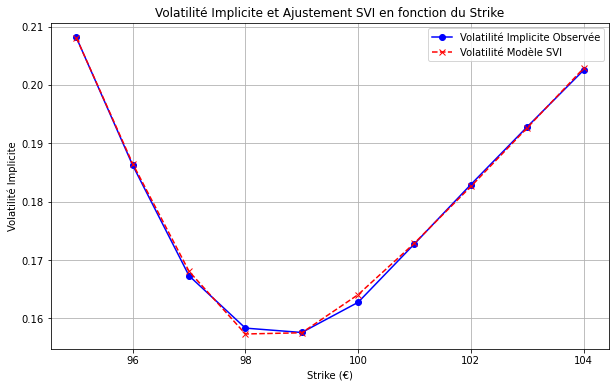

In [8]:
svi_vols = svi_model(log_moneyness, a, b, rho, m, sigma)

plt.figure(figsize=(10, 6))
plt.plot(strike, implied_vols, marker='o', linestyle='-', color='b', label='Volatilité Implicite Observée')
plt.plot(strike, svi_vols, marker='x', linestyle='--', color='r', label='Volatilité Modèle SVI')
plt.xlabel('Strike (€)')
plt.ylabel('Volatilité Implicite')
plt.title('Volatilité Implicite et Ajustement SVI en fonction du Strike')
plt.legend()
plt.grid(True)
plt.show()


Definition du modele svi generalisé et de sa cost function

In [9]:
def svi_generalized_model(x, a, b, rho, m, sigma, beta):
    z = x  / (beta ** np.abs(x - m)) 
    return a + b * (rho * z + np.sqrt(z**2 + sigma**2))

def cost_function_generalized(params, x_data, y_data):
    a, b, rho, m, sigma, beta = params
    y_pred = svi_generalized_model(x_data, a, b, rho, m, sigma, beta)
    return np.sum((y_data - y_pred)**2)

definition des parametres de départ et optimisation

In [10]:
a_g, b_g, rho_g, m_g, sigma_g, beta_g = 0.1, 0.1, -0.1, 0.0, 0.1, 1.25
#a, b, rho, m, sigma, beta = 0.1, 1.8, -0.3, -0.021, 0.01, 5
params_generalized = np.array([a_g, b_g, rho_g, m_g, sigma_g, beta_g])

params_optimized_generalized = nelder_mead(params_generalized, cost_function_generalized, log_moneyness, implied_vols)
a_g, b_g, rho_g, m_g, sigma_g, beta_g = params_optimized_generalized

print(f"Paramètres calibrés avec Nelder-Mead (SVI Généralisée) : a={a_g}, b={b_g}, rho={rho_g}, m={m_g}, sigma={sigma_g}, beta={beta_g}")

Paramètres calibrés avec Nelder-Mead (SVI Généralisée) : a=0.04738673756240744, b=0.14058448542298385, rho=0.33825723824102044, m=0.3423877832287773, sigma=-0.8333148764113061, beta=0.00026381738240097684


Calcul des vols par le model svi generalisé et plot

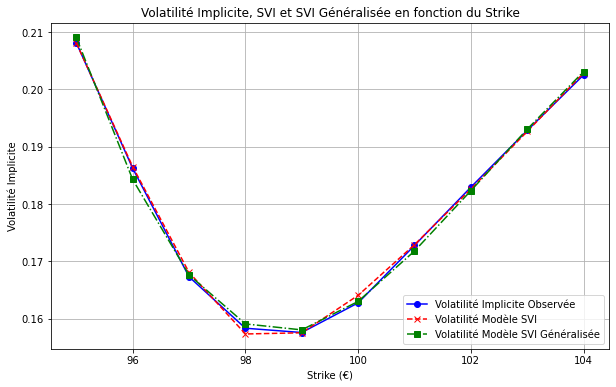

In [11]:
generalized_svi_vols = svi_generalized_model(log_moneyness, a_g, b_g, rho_g, m_g, sigma_g, beta_g)

plt.figure(figsize=(10, 6))
plt.plot(strike, implied_vols, marker='o', linestyle='-', color='b', label='Volatilité Implicite Observée')
plt.plot(strike, svi_vols, marker='x', linestyle='--', color='r', label='Volatilité Modèle SVI')
plt.plot(strike, generalized_svi_vols, marker='s', linestyle='-.', color='g', label='Volatilité Modèle SVI Généralisée')
plt.xlabel('Strike (€)')
plt.ylabel('Volatilité Implicite')
plt.title('Volatilité Implicite, SVI et SVI Généralisée en fonction du Strike')
plt.legend()
plt.grid(True)
plt.show()


In [12]:


def dupire_local_volatility(a, b, rho, m, sigma,S=100, T=1, rf=0.002, model='svi_model', beta=1.25):
    price_strikes = np.arange(89.99, 110.02, 0.01)
    log_moneyness_fine = np.log(price_strikes / (S*(1+rf*T)))
    log_moneyness_fine_inf = np.log(price_strikes / (S*(1+rf*(T-1/365))))
    log_moneyness_fine_sup = np.log(price_strikes / (S*(1+rf*(T+1/365))))


    if model == 'generalized_svi_model' or model == 'g' or model == 'generalized':
        vols_svi = svi_generalized_model(log_moneyness_fine, a, b, rho, m, sigma, beta)
        vols_svi_inf = svi_generalized_model(log_moneyness_fine_inf, a, b, rho, m, sigma, beta)
        vols_svi_sup = svi_generalized_model(log_moneyness_fine_sup, a, b, rho, m, sigma, beta)
    else:
        vols_svi = svi_model(log_moneyness_fine, a, b, rho, m, sigma)
        vols_svi_inf = svi_model(log_moneyness_fine_inf, a, b, rho, m, sigma)
        vols_svi_sup = svi_model(log_moneyness_fine_sup, a, b, rho, m, sigma)

    option_price_strikes = [black_scholes_call_price_for_IM(S, K, T, rf, vol) for K, vol in zip(price_strikes, vols_svi)]
    option_price_strikes_inf = [black_scholes_call_price_for_IM(S, K, T-1/365, rf, vol) for K, vol in zip(price_strikes, vols_svi_inf)]
    option_price_strikes_sup = [black_scholes_call_price_for_IM(S, K, T+1/365, rf, vol) for K, vol in zip(price_strikes, vols_svi_sup)]

    print(option_price_strikes)
    


    plt.figure(figsize=(10, 6))
    plt.plot(price_strikes, option_price_strikes, linestyle='-', color='b', label='Prix des Options')
    plt.plot(price_strikes, option_price_strikes, linestyle='-', color='b', label='Prix des Options')
    plt.plot(price_strikes, option_price_strikes_inf, linestyle='--', color='r', label='Prix des Options (T-1/365)')
    plt.plot(price_strikes, option_price_strikes_sup, linestyle='--', color='g', label='Prix des Options (T+1/365)')
    plt.xlabel('Strike (€)')
    plt.ylabel('Prix de l\'Option')
    plt.title('Prix des Options en fonction du Strike')
    plt.legend()
    plt.grid(True)
    plt.show()

    dK = 0.01
    dC_dK = [(option_price_strikes[i+1] - option_price_strikes[i-1]) / (2 * dK) for i in range(1, len(price_strikes) - 1)]
    d2C_dK2 = [(option_price_strikes[i+1] - 2 * option_price_strikes[i] + option_price_strikes[i-1]) / dK**2 for i in range(1, len(price_strikes) - 1)]

    plt.figure(figsize=(10, 6))
    plt.plot(price_strikes[1:-1], dC_dK, linestyle='-', color='b', label='derivée première')
    plt.plot(price_strikes[1:-1], d2C_dK2, linestyle='--', color='r', label='derivée seconde')
    plt.xlabel('Strike (€)')
    plt.ylabel('Prix de l\'Option')
    plt.title('Prix des Options en fonction du Strike')
    plt.legend()
    plt.grid(True)
    plt.show()


    dC_dT = [(option_price_strikes_sup[i] - option_price_strikes_inf[i]) / (2 * 1/365) for i in range(1, len(price_strikes) - 1)]

    local_volatility = [max(0,np.sqrt(2*( dC_dT + rf * price_strikes * dC_dK) / (price_strikes**2 * d2C_dK2))) for price_strikes,dC_dT,dC_dK, d2C_dK2 in zip(price_strikes,dC_dT,dC_dK, d2C_dK2)]



    plt.figure(figsize=(10, 6))
    #plt.plot(strike, implied_vols, marker='o', linestyle='-', color='b', label='Volatilité Implicite Observée')
    plt.plot(price_strikes[1:-1], local_volatility, linestyle='--', color='orange', label='Volatilité Locale')
    plt.xlabel('Strike (€)')
    plt.ylabel('Volatilité ')
    plt.title('Volatilité Implicite et Volatilité Locale en fonction du Strike')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price_strikes, local_volatility

[18.15543129415508, 18.140846548322024, 18.12626196009581, 18.11167753081635, 18.097093261828817, 18.08250915448378, 18.067925210137197, 18.053341430150354, 18.038757815890108, 18.02417436872873, 18.009591090043983, 17.995007981219224, 17.980425043643294, 17.965842278710802, 17.951259687821867, 17.936677272382298, 17.922095033803693, 17.9075129735033, 17.89293109290424, 17.878349393435364, 17.863767876531433, 17.84918654363306, 17.834605396186767, 17.820024435645067, 17.80544366346645, 17.790863081115447, 17.7762826900626, 17.761702491784604, 17.747122487764294, 17.732542679490635, 17.71796306845885, 17.703383656170395, 17.688804444132998, 17.67422543386074, 17.65964662687408, 17.645068024699803, 17.63048962887123, 17.61591144092813, 17.601333462416775, 17.58675569489001, 17.572178139907294, 17.55760079903476, 17.543023673845127, 17.528446765917927, 17.513870076839446, 17.499293608202784, 17.484717361607835, 17.470141338661435, 17.455565540977354, 17.440989970176354, 17.426414627886167

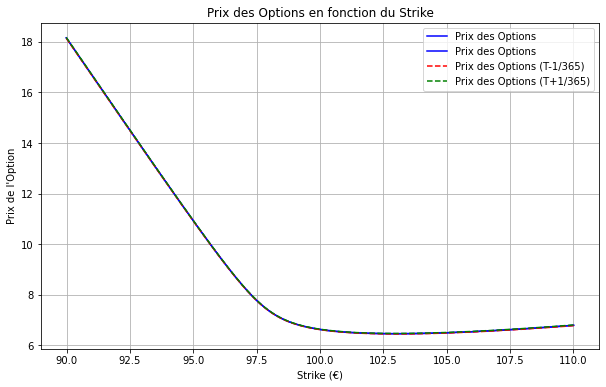

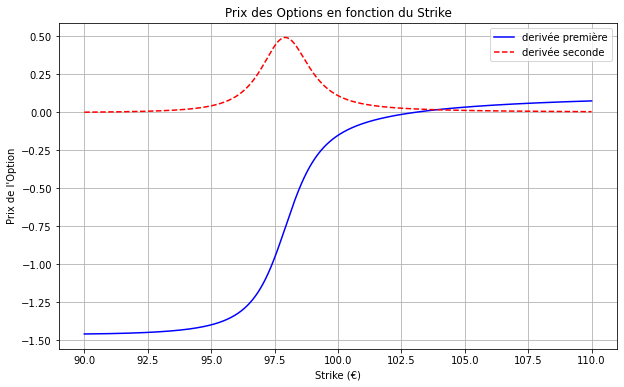

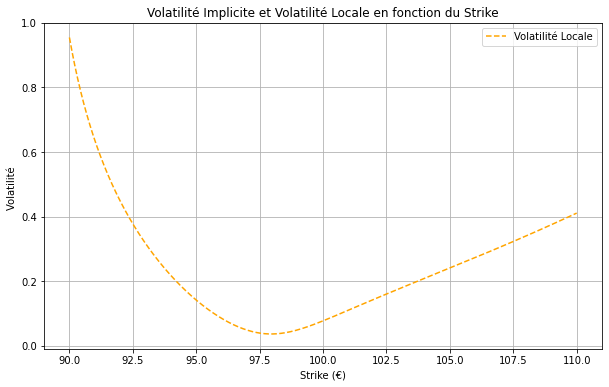

In [13]:
price_strikes,local_volatility =dupire_local_volatility(a, b, rho, m, sigma)
#price_strikes,local_volatility =dupire_local_volatility(a_g, b_g, rho_g, m_g, sigma_g, model='generalized_svi_model', beta=1.25)

Question 4

In [14]:
strike_Q4 = np.array([99, 100, 101])
prices_Q4 = np.array([6.86, 6.58, 6.52])
S = 100
rf = 0.002
T = 1

implied_vols_Q4 = []
for K, price in zip(strike_Q4, prices_Q4):
    vol = implied_volatility(price, S, K, T, rf)
    implied_vols_Q4.append(vol)

results_Q4 = pd.DataFrame({"Strike": strike_Q4, "Option Price": prices_Q4, "Implied Volatility": implied_vols_Q4})
print(results_Q4)

   Strike  Option Price  Implied Volatility
0      99          6.86            0.157592
1     100          6.58            0.162762
2     101          6.52            0.172779


In [15]:
log_moneyness_Q4 = np.log(strike_Q4 / (S*(1+rf*T)))
print(log_moneyness_Q4)

a_Q4, b_Q4, rho_Q4, m_Q4, sigma_Q4 = 0.1, 0.1, -0.1, 0.0, 0.1
params_Q4 = np.array([a_Q4, b_Q4, rho_Q4, m_Q4, sigma_Q4])

params_optimized_Q4 = nelder_mead(params_Q4, cost_function_1, log_moneyness_Q4, implied_vols_Q4)
a_Q4, b_Q4, rho_Q4, m_Q4, sigma_Q4 = params_optimized_Q4

print(f"Paramètres calibrés avec Nelder-Mead : a={a_Q4}, b={b_Q4}, rho={rho_Q4}, m={m_Q4}, sigma={sigma_Q4}")

[-0.01204834 -0.001998    0.00795233]
Paramètres calibrés avec Nelder-Mead : a=0.14330634409038884, b=0.9776210357649092, rho=0.6697239921204954, m=-0.004282156063552058, sigma=-0.01822843325209278


In [16]:
print(strike_Q4)
print(implied_vols_Q4)
print(log_moneyness_Q4)

[ 99 100 101]
[0.1575919911265373, 0.1627616965949535, 0.17277895087003706]
[-0.01204834 -0.001998    0.00795233]


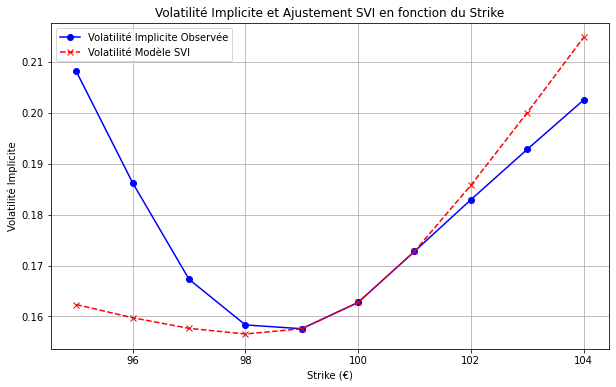

In [17]:
svi_vols_Q4 = svi_model(log_moneyness, *params_optimized_Q4)

plt.figure(figsize=(10, 6))
plt.plot(strike, implied_vols, marker='o', linestyle='-', color='b', label='Volatilité Implicite Observée')
plt.plot(strike, svi_vols_Q4, marker='x', linestyle='--', color='r', label='Volatilité Modèle SVI')
plt.xlabel('Strike (€)')
plt.ylabel('Volatilité Implicite')
plt.title('Volatilité Implicite et Ajustement SVI en fonction du Strike')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
a_g_Q4, b_g_Q4, rho_g_Q4, m_g_Q4, sigma_g_Q4, beta_g_Q4 = 0.1, 0.1, -0.1, 0.0, 0.1, 1.25
#a, b, rho, m, sigma, beta = 0.1, 1.8, -0.3, -0.021, 0.01, 5
params_generalized_Q4 = np.array([a_g_Q4, b_g_Q4, rho_g_Q4, m_g_Q4, sigma_g_Q4, beta_g_Q4])

params_optimized_generalized_Q4 = nelder_mead(params_generalized_Q4, cost_function_generalized, log_moneyness_Q4, implied_vols_Q4)
a_g_Q4, b_g_Q4, rho_g_Q4, m_g_Q4, sigma_g_Q4, beta_g_Q4 = params_optimized_generalized_Q4

print(f"Paramètres calibrés avec Nelder-Mead (SVI Généralisée) : a={a_g_Q4}, b={b_g_Q4}, rho={rho_g_Q4}, m={m_g_Q4}, sigma={sigma_g_Q4}, beta={beta_g_Q4}")

Paramètres calibrés avec Nelder-Mead (SVI Généralisée) : a=0.16367378417946915, b=0.2939277273654888, rho=2.595518372647678, m=-2.4220217135221986, sigma=-0.0012567899380278899, beta=0.9687478302187726


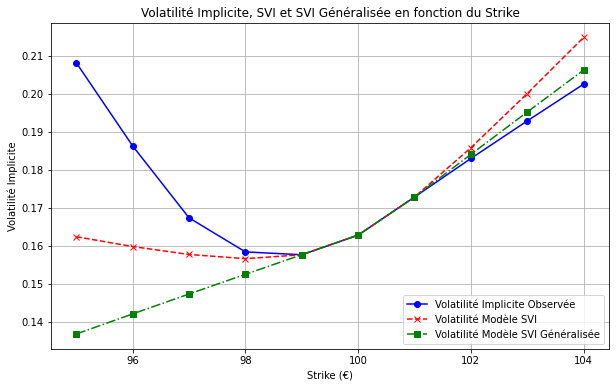

In [19]:
generalized_svi_vols_Q4 = svi_generalized_model(log_moneyness, a_g_Q4, b_g_Q4, rho_g_Q4, m_g_Q4, sigma_g_Q4, beta_g_Q4)

plt.figure(figsize=(10, 6))
plt.plot(strike, implied_vols, marker='o', linestyle='-', color='b', label='Volatilité Implicite Observée')
plt.plot(strike, svi_vols_Q4, marker='x', linestyle='--', color='r', label='Volatilité Modèle SVI')
plt.plot(strike, generalized_svi_vols_Q4, marker='s', linestyle='-.', color='g', label='Volatilité Modèle SVI Généralisée')
plt.xlabel('Strike (€)')
plt.ylabel('Volatilité Implicite')
plt.title('Volatilité Implicite, SVI et SVI Généralisée en fonction du Strike')
plt.legend()
plt.grid(True)
plt.show()


[13.017483274743775, 13.009459610158707, 13.001437497310327, 12.993416937662431, 12.98539793268111, 12.97738048383463, 12.969364592593585, 12.961350260430685, 12.953337488821, 12.945326279241812, 12.937316633172685, 12.929308552095463, 12.92130203749425, 12.913297090855494, 12.905293713667888, 12.897291907422485, 12.889291673612611, 12.881293013733945, 12.873295929284474, 12.86530042176453, 12.857306492676877, 12.849314143526513, 12.841323375820892, 12.833334191069767, 12.82534659078538, 12.817360576482237, 12.809376149677355, 12.801393311890095, 12.793412064642311, 12.785432409458153, 12.777454347864335, 12.769477881389975, 12.76150301156661, 12.753529739928318, 12.745558068011519, 12.73758799735527, 12.729619529500965, 12.721652665992643, 12.713687408376728, 12.705723758202247, 12.697761717020725, 12.6898012863862, 12.681842467855283, 12.673885262987113, 12.665929673343449, 12.657975700488585, 12.65002334598939, 12.642072611415308, 12.634123498338475, 12.626176008333559, 12.618230142

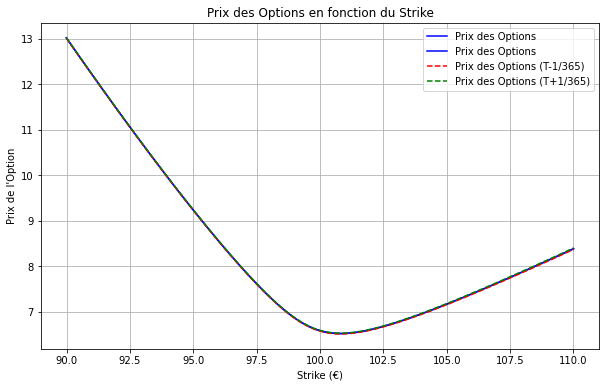

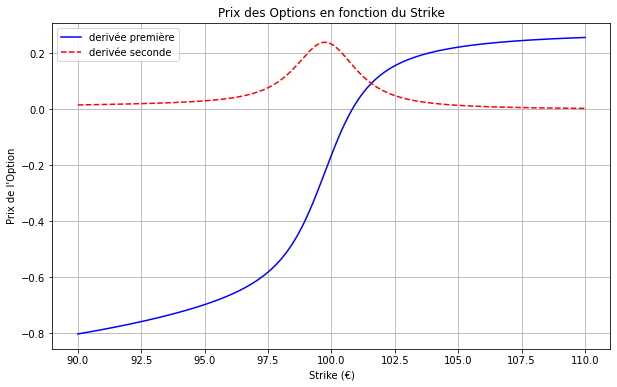

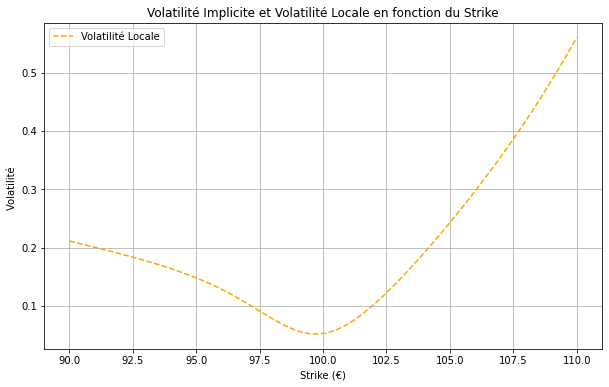

In [20]:
price_strikes_Q4,local_volatility_Q4 =dupire_local_volatility(a_Q4, b_Q4, rho_Q4, m_Q4, sigma_Q4)

comparaison Q3 Q5

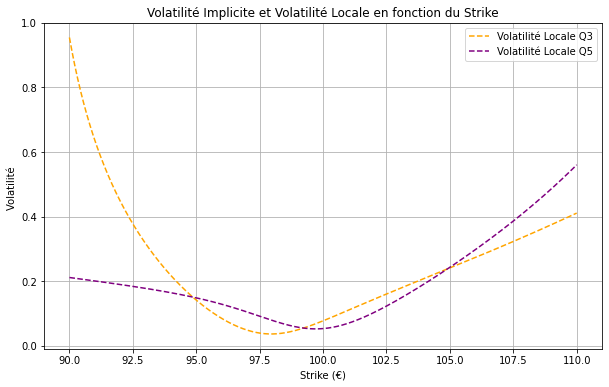

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(price_strikes[1:-1], local_volatility, linestyle='--', color='orange', label='Volatilité Locale Q3')
plt.plot(price_strikes_Q4[1:-1], local_volatility_Q4, linestyle='--', color='purple', label='Volatilité Locale Q5')
plt.xlabel('Strike (€)')
plt.ylabel('Volatilité ')
plt.title('Volatilité Implicite et Volatilité Locale en fonction du Strike')
plt.legend()
plt.grid(True)
plt.show()

Q6

In [22]:
prices_stressed_down = prices.copy()
prices_stressed_up = prices.copy()
print("prices : ",prices)

index_102 = np.where(strike == 102)[0][0]
index_101 = np.where(strike == 101)[0][0]
index_100 = np.where(strike == 100)[0][0]
index_99 = np.where(strike == 99)[0][0]

while prices_stressed_up[index_100] + 0.02 < prices_stressed_up[index_99] and (prices_stressed_up[index_100] < 0.5* (prices_stressed_up[index_99] + prices_stressed_up[index_101])) :

    prices_stressed_up[index_100] += 0.01


while prices_stressed_down[index_100] - 0.02 > prices_stressed_down[index_101] and \
        (prices_stressed_down[index_100] < 0.5*(prices_stressed_down[index_99] + prices_stressed_down[index_101]))\
        and (prices_stressed_down[index_101] < 0.5*(prices_stressed_down[index_100] + prices_stressed_down[index_102])) :
    
    prices_stressed_down[index_100] -= 0.01
    
print("prices_stressed_up :",prices_stressed_up)
print("prices_stressed_down : ",prices_stressed_down)


prices :  [10.93  9.55  8.28  7.4   6.86  6.58  6.52  6.49  6.47  6.46]
prices_stressed_up : [10.93  9.55  8.28  7.4   6.86  6.7   6.52  6.49  6.47  6.46]
prices_stressed_down :  [10.93  9.55  8.28  7.4   6.86  6.54  6.52  6.49  6.47  6.46]


Paramètres calibrés avec Nelder-Mead pour prices down : a=0.161801815206521, b=0.20070590934081872, rho=0.12286581970697258, m=-0.012048339971123881, sigma=-1.4039450794395113e-10
Paramètres calibrés avec Nelder-Mead pour prices up : a=0.017991308779075278, b=0.26186284013588157, rho=1.900052510000962, m=-0.19611921440673458, sigma=-3.108824537630415e-09


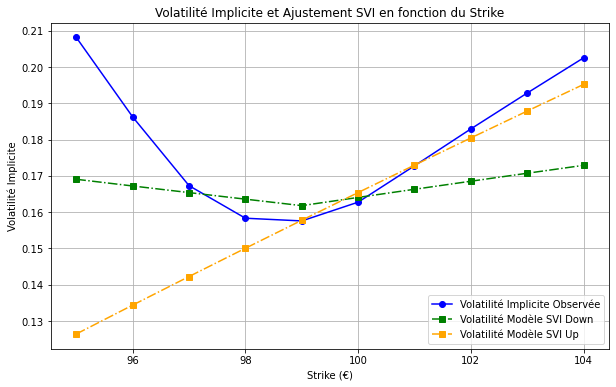

[13.030498847788522, 13.022940647434773, 13.015384183932916, 13.007829458146851, 13.000276470940513, 12.992725223177764, 12.985175715722477, 12.9776279494385, 12.970081925189689, 12.962537643839859, 12.954995106252781, 12.947454313292269, 12.939915265822073, 12.932377964705935, 12.92484241080755, 12.917308604990659, 12.909776548118899, 12.902246241055941, 12.894717684665402, 12.887190879810895, 12.879665827356007, 12.872142528164282, 12.864620983099258, 12.857101193024405, 12.849583158803256, 12.84206688129919, 12.834552361375671, 12.827039599896075, 12.819528597723767, 12.81201935572205, 12.804511874754269, 12.797006155683654, 12.789502199373466, 12.782000006686886, 12.774499578487053, 12.767000915637176, 12.759504019000282, 12.752008889439487, 12.744515527817796, 12.737023934998156, 12.729534111843599, 12.722046059217014, 12.714559777981265, 12.707075268999183, 12.699592533133604, 12.692111571247231, 12.684632384202821, 12.677154972863036, 12.669679338090518, 12.66220548074785, 12.65

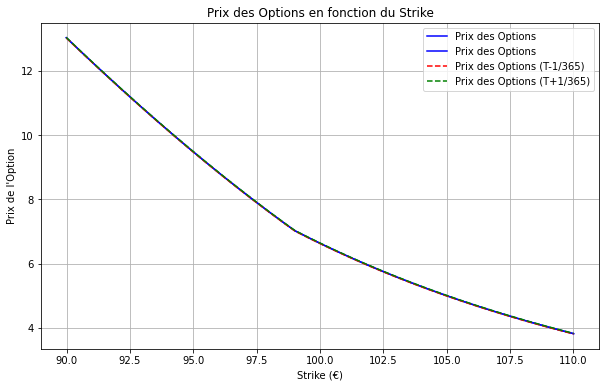

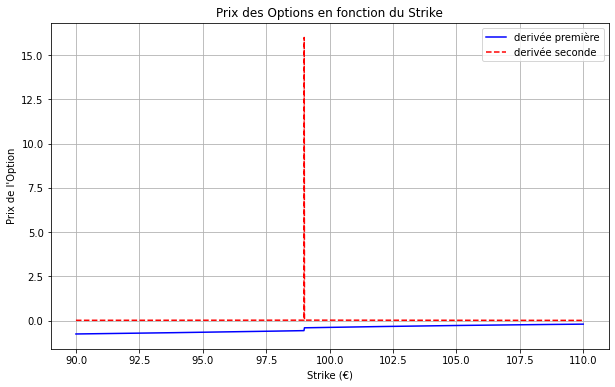

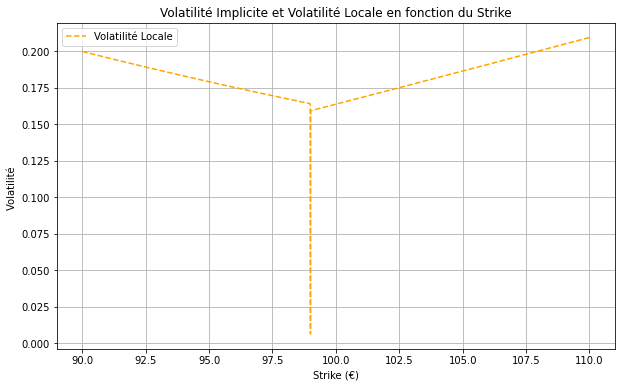

[10.590303022831591, 10.582885059602987, 10.575476561325814, 10.568077528555492, 10.56068796175461, 10.553307861293334, 10.545937227449983, 10.53857606041143, 10.531224360273725, 10.52388212704247, 10.516549360633405, 10.50922606087289, 10.501912227498309, 10.494607860158666, 10.487312958415146, 10.480027521741349, 10.47275154952412, 10.465485041063786, 10.458227995574731, 10.450980412185984, 10.443742289941525, 10.436513627800935, 10.429294424639863, 10.42208467925039, 10.414884390341697, 10.407693556540465, 10.40051217639133, 10.393340248357404, 10.386177770820836, 10.379024742083189, 10.371881160365973, 10.364747023811148, 10.357622330481504, 10.350507078361346, 10.343401265356789, 10.33630488929633, 10.329217947931198, 10.32214043893616, 10.31507235990955, 10.308013708374148, 10.300964481777399, 10.293924677491987, 10.2868942928163, 10.279873324974886, 10.272861771119025, 10.265859628326965, 10.258866893604704, 10.251883563886153, 10.244909636033881, 10.237945106839362, 10.23098997

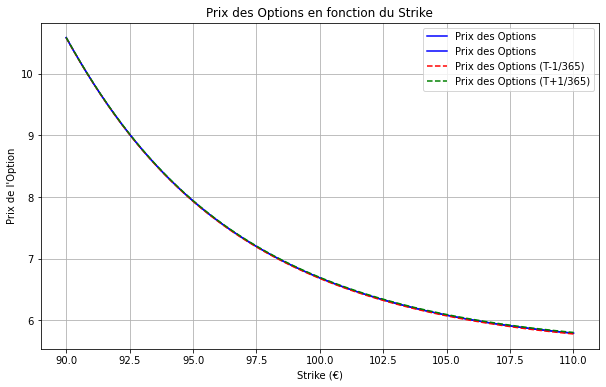

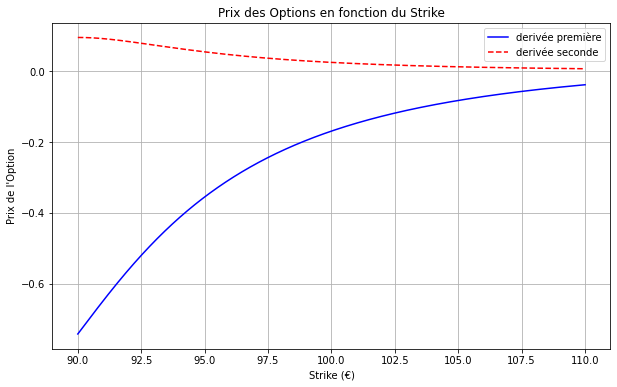

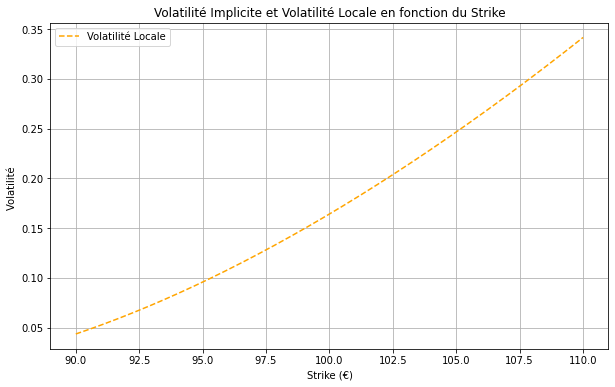

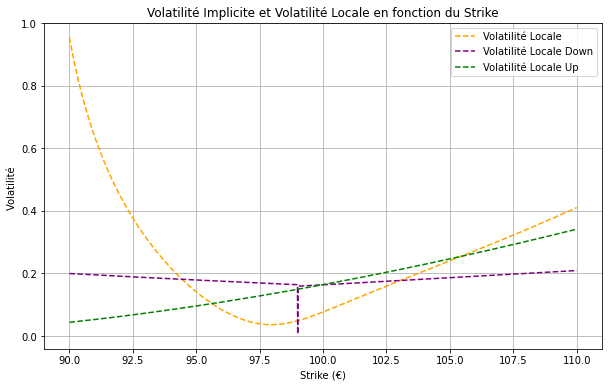

In [23]:
strike_Q6 = np.array([99, 100, 101])
prices_down_Q6 = np.array([prices_stressed_down[index_99], prices_stressed_down[index_100], prices_stressed_down[index_101]])
prices_up_Q6 = np.array([prices_stressed_up[index_99], prices_stressed_up[index_100], prices_stressed_up[index_101]])

implied_vols_down_Q6 = []
implied_vols_up_Q6 = []

for K, price_down in zip(strike_Q6, prices_down_Q6):
    vol1 = implied_volatility(price_down, S, K, T, rf)
    implied_vols_down_Q6.append(vol1)

for K, price_up in zip(strike_Q6, prices_up_Q6):
    vol2 = implied_volatility(price_up, S, K, T, rf)
    implied_vols_up_Q6.append(vol2)

log_moneyness_Q6 = np.log(strike_Q6 / (S*(1+rf*T)))

a_down_Q6, b_down_Q6, rho_down_Q6, m_down_Q6, sigma_down_Q6 = 0.1, 0.1, -0.1, 0.0, 0.1
params_down_Q6 = np.array([a_down_Q6, b_down_Q6, rho_down_Q6, m_down_Q6, sigma_down_Q6])
a_up_Q6, b_up_Q6, rho_up_Q6, m_up_Q6, sigma_up_Q6 = 0.1, 0.1, -0.1, 0.0, 0.1
params_up_Q6 = np.array([a_up_Q6, b_up_Q6, rho_up_Q6, m_up_Q6, sigma_up_Q6])

params_optimized_down_Q6 = nelder_mead(params_down_Q6, cost_function_1, log_moneyness_Q6, implied_vols_down_Q6)
a_down_Q6, b_down_Q6, rho_down_Q6, m_down_Q6, sigma_down_Q6 = params_optimized_down_Q6

params_optimized_up_Q6 = nelder_mead(params_up_Q6, cost_function_1, log_moneyness_Q6, implied_vols_up_Q6)
a_up_Q6, b_up_Q6, rho_up_Q6, m_up_Q6, sigma_up_Q6 = params_optimized_up_Q6

print(f"Paramètres calibrés avec Nelder-Mead pour prices down : a={a_down_Q6}, b={b_down_Q6}, rho={rho_down_Q6}, m={m_down_Q6}, sigma={sigma_down_Q6}")
print(f"Paramètres calibrés avec Nelder-Mead pour prices up : a={a_up_Q6}, b={b_up_Q6}, rho={rho_up_Q6}, m={m_up_Q6}, sigma={sigma_up_Q6}")

svi_vols_up_Q6 = svi_model(log_moneyness, a_up_Q6, b_up_Q6, rho_up_Q6, m_up_Q6, sigma_up_Q6)
svi_vols_down_Q6 = svi_model(log_moneyness, a_down_Q6, b_down_Q6, rho_down_Q6, m_down_Q6, sigma_down_Q6)

plt.figure(figsize=(10, 6))
plt.plot(strike, implied_vols, marker='o', linestyle='-', color='b', label='Volatilité Implicite Observée')
plt.plot(strike, svi_vols_down_Q6, marker='s', linestyle='-.', color='g', label='Volatilité Modèle SVI Down')
plt.plot(strike, svi_vols_up_Q6, marker='s', linestyle='-.', color='orange', label='Volatilité Modèle SVI Up')
plt.xlabel('Strike (€)')
plt.ylabel('Volatilité Implicite')
plt.title('Volatilité Implicite et Ajustement SVI en fonction du Strike')
plt.legend()
plt.grid(True)
plt.show()

price_strikes_down_Q6,local_volatility_down_Q6 =dupire_local_volatility(a_down_Q6, b_down_Q6, rho_down_Q6, m_down_Q6, sigma_down_Q6)
price_strikes_up_Q6,local_volatility_up_Q6 =dupire_local_volatility(a_up_Q6, b_up_Q6, rho_up_Q6, m_up_Q6, sigma_up_Q6)

plt.figure(figsize=(10, 6))
plt.plot(price_strikes[1:-1], local_volatility, linestyle='--', color='orange', label='Volatilité Locale')
plt.plot(price_strikes_down_Q6[1:-1], local_volatility_down_Q6, linestyle='--', color='purple', label='Volatilité Locale Down')
plt.plot(price_strikes_up_Q6[1:-1], local_volatility_up_Q6, linestyle='--', color='green', label='Volatilité Locale Up')
plt.xlabel('Strike (€)')
plt.ylabel('Volatilité ')
plt.title('Volatilité Implicite et Volatilité Locale en fonction du Strike')
plt.legend()
plt.grid(True)
plt.show()

PARTIE 2

In [46]:
def nelder_mead(initial_params, cost_function, x_data, y_data, tol=1e-6, max_iter=1000):
    n = len(initial_params)
    new_params = [np.array(initial_params)]
    for i in range(n):
        noise_params = np.array(initial_params).copy()
        noise_params[i] += 0.1
        new_params.append(noise_params)

    for step in range(max_iter):
        new_params.sort(key=lambda params: cost_function(params, x_data, y_data))
        best = new_params[0]
        worst = new_params[-1]
        second_worst = new_params[-2]

        x0 = np.mean(new_params[:-1], axis=0)

        xr = x0 + (x0 - worst)
        if cost_function(xr, x_data, y_data) < cost_function(best, x_data, y_data):
            xe = x0 + 2 * (x0 - worst)
            if cost_function(xe, x_data, y_data) < cost_function(xr, x_data, y_data):
                new_params[-1] = xe
            else:
                new_params[-1] = xr
        elif cost_function(xr, x_data, y_data) < cost_function(second_worst, x_data, y_data):
            new_params[-1] = xr
        else:
            xc = x0 + 0.5 * (worst - x0)
            if cost_function(xc, x_data, y_data) < cost_function(worst, x_data, y_data):
                new_params[-1] = xc
            else:
                for i in range(1, len(new_params)):
                    new_params[i] = best + 0.5 * (new_params[i] - best)

        distances = [np.linalg.norm(np.array(new_params[i]) - best) for i in range(1, len(new_params))]
        if np.max(distances) < tol:
            break

    return best

   Strikes  Prices  HestonPrice
0       95   10.93    11.411657
1       96    9.55    10.834906
2       97    8.28    10.276592
3       98    7.40     9.736846
4       99    6.86     9.215754
5      100    6.58     8.713365
6      101    6.52     8.229681
7      102    6.49     7.764664
8      103    6.47     7.318232
9      104    6.46     6.890261


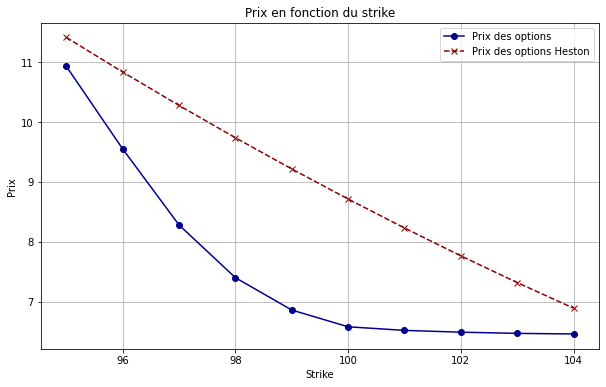

Best params : kappa=2.0381789656939375, theta=0.024181204960624814, sigma=0.3507685522039328, rho=-0.5335167688297956, v0=0.05108089859675349
Cost final : 5.405966192609224
Best params (ATM) : kappa=2.0227142534135725, theta=0.019381505796743494, sigma=0.36814372382109994, rho=-0.540652662888111, v0=0.04855914097123516
Cost final (ATM) = 0.31151790738403723
Best params (price stressed up) : kappa=2.018100190689598, theta=0.03288767794609475, sigma=0.35018952154602423, rho=-0.4490007519880994, v0=0.03768776024380841
Cost final (price streesed up) = 3.826796069553655
Best params (price stressed down) : kappa=2.039991266810284, theta=0.031129247570301496, sigma=0.33983165889863665, rho=-0.4872256898640667, v0=0.039374960310151454
Cost final (price stressed down) = 6.053537211820535


In [48]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
import math

def heston_cf(u, spot, var0, kappa, theta, sigma, rho, tau, rate):
  i  = 1j
  a  = kappa * theta
  rspi = rho * sigma * u * i

  dval = np.sqrt((rspi - kappa)**2 + (u*i + u**2)*sigma**2)
  gval = (kappa - rspi + dval)/(kappa - rspi - dval)

  factor1 = np.exp(rate * u * i * tau)
  factor2 = spot**(u * i) * ((1 - gval * np.exp(dval * tau)) 
                             / (1 - gval))**(-2*a/sigma**2)

  factor3 = np.exp(a * tau * (kappa - rspi + dval)/sigma**2
                     + var0 * (kappa - rspi + dval)*(1 - np.exp(dval*tau))
                       /(sigma**2 * (1 - gval*np.exp(dval*tau))))

  return factor1 * factor2 * factor3

def heston_integrand(u, spot, var0, kappa, theta, sigma, rho, tau, rate, strike):
  i = 1j
  params = (spot, var0, kappa, theta, sigma, rho, tau, rate)

  num   = math.exp(-rate * tau) * heston_cf(u - i, *params) \
                  - strike * heston_cf(u, *params)
  denom       = i * u * (strike**(i*u))

  return (num / denom).real

def heston_call_price(spot, var0, kappa, theta, sigma, rho, tau, rate, strike):
    pars_for_integrand = (spot, var0, kappa, theta, sigma, rho, tau, rate, strike)
    val, _ = quad(heston_integrand, 0, 100, args=pars_for_integrand, limit=200)
    return (spot - strike * math.exp(-rate * tau))/2.0 + val / math.pi

df = pd.DataFrame({'Strikes': strike, 'Prices': prices})

# Paramètres Heston
kappa = 2.0
theta = 0.05
sigma = 0.3
rho   = -0.5
var0  = 0.05

# Calcul des prix
list_heston = []
for K in strike:
    c_heston = heston_call_price(
        spot=S, var0=var0,
        kappa=kappa, theta=theta, sigma=sigma, rho=rho,
        tau=T, rate=rf,
        strike=K
    )
    list_heston.append(c_heston)

df['HestonPrice'] = list_heston
print(df[['Strikes', 'Prices', 'HestonPrice']])

plt.figure(figsize=(10, 6))
plt.plot(strike, prices, 'o', linestyle='-', color='darkblue', label='Prix des options')
plt.plot(strike, list_heston, 'x', linestyle='--', color='darkred', label='Prix des options Heston')
plt.title('Prix en fonction du strike')
plt.xlabel('Strike')
plt.ylabel('Prix')
plt.grid()
plt.legend()
plt.show()


def simulate_heston_paths(S0, v0, kappa, theta, sigma, rho, r,
                          T=1.0, n_paths=10000, n_steps=200):

    dt = T / n_steps

    # On stocke S et V à l'instant t
    S = np.full(n_paths, S0, dtype=float)
    V = np.full(n_paths, v0, dtype=float)

    # Matrice de covariance 2x2 pour le vecteur (dW1, dW2)
    cov_2x2 = np.array([
        [1.0, rho],
        [rho, 1.0]
    ])
    L = np.linalg.cholesky(cov_2x2)

    for step in range(n_steps):
        # Génération Gauss (N(0,1)) i.i.d
        Z = np.random.randn(n_paths, 2)
        # Corrélation via Cholesky
        Zcorr = Z @ L.T  # shape (n_paths,2)

        dW1 = Zcorr[:,0]*math.sqrt(dt)
        dW2 = Zcorr[:,1]*math.sqrt(dt)

        # Update variance (Euler)
        # V_{t+dt} = V_t + kappa*(theta - V_t)*dt + sigma*sqrt(V_t)*dW2
        Vnew = V + kappa*(theta - V)*dt + sigma*np.sqrt(np.maximum(V,0.0))*dW2
        # forcer V>=0
        Vnew = np.maximum(Vnew, 0.0)

        # Update spot : schéma additif :
        # dS = r*S dt + sqrt(V_t)*S dW1
        Snew = S + r*S*dt + np.sqrt(np.maximum(V,0.0))*S*dW1
        Snew = np.maximum(Snew, 1e-12)  # éviter Sneg

        S = Snew
        V = Vnew

    return S  # S_T final shape (n_paths,)


def heston_mc_call_price(S0, v0, kappa, theta, sigma, rho, r,
                         T, strike, n_paths=10000, n_steps=200):

    S_T = simulate_heston_paths(S0, v0, kappa, theta, sigma, rho, r,
                                T=T, n_paths=n_paths, n_steps=n_steps)
    payoff = np.maximum(S_T - strike, 0.0)
    return math.exp(-r*T)*np.mean(payoff)

def cost_heston_mc(params, strikes, market_prices):

    global S, r, T

    kappa, theta, sigma, rho, v0 = params

    # Pénalités si param out of domain
    if kappa<=1e-8 or theta<=1e-8 or sigma<=1e-8 or v0<=1e-8 or abs(rho)>=1.0:
        return 1e10

    # Param MC
    n_paths = 3000   # ajuster au besoin
    n_steps = 100

    sse = 0.0
    for K, obs in zip(strikes, market_prices):
        c_mc = heston_mc_call_price(S, v0, kappa, theta, sigma, rho, r,
                                    T, K, n_paths, n_steps)
        diff = c_mc - obs
        sse += diff*diff
    return sse

globals()['S'] = S
globals()['r'] = rf
globals()['T'] = T

kappa, theta, sigma, rho, v0 = 2.0, 0.05, 0.3, -0.5, 0.05
initial_guess = [kappa, theta, sigma, rho, v0]
best_params = nelder_mead(initial_guess, cost_function=cost_heston_mc, x_data=strike, y_data=prices, tol=1e-4, max_iter=100)

print(f"Best params : kappa={best_params[0]}, theta={best_params[1]}, sigma={best_params[2]}, rho={best_params[3]}, v0={best_params[4]}")
cost = cost_heston_mc(best_params, strike, prices)
print("Cost final :", cost)

idx_atm = [i for i,k in enumerate(strike) if k in [99,100,101]]
st_atm  = [strike[i] for i in idx_atm]
pr_atm  = [prices[i]  for i in idx_atm]

best_params_atm = nelder_mead(initial_guess, cost_function=cost_heston_mc, x_data=st_atm, y_data=pr_atm, tol=1e-4, max_iter=100)

print(f"Best params (ATM) : kappa={best_params_atm[0]}, theta={best_params_atm[1]}, sigma={best_params_atm[2]}, rho={best_params_atm[3]}, v0={best_params_atm[4]}")
cost_atm = cost_heston_mc(best_params_atm, st_atm, pr_atm)
print("Cost final (ATM) =", cost_atm)

df_mod = df.copy()
idx_100 = df_mod.index[df_mod['Strikes']==100][0]
df_mod.loc[idx_100,'Prices'] = 6.7

best_params_mod = nelder_mead(initial_guess, cost_function=cost_heston_mc, x_data=df_mod['Strikes'].values, y_data=df_mod['Prices'].values, tol=1e-4, max_iter=100)

print(f"Best params (price stressed up) : kappa={best_params_mod[0]}, theta={best_params_mod[1]}, sigma={best_params_mod[2]}, rho={best_params_mod[3]}, v0={best_params_mod[4]}")
cost_mod = cost_heston_mc(best_params_mod, df_mod['Strikes'].values, df_mod['Prices'].values)
print("Cost final (price streesed up) =", cost_mod)

df_mod = df.copy()
idx_100 = df_mod.index[df_mod['Strikes']==100][0]
df_mod.loc[idx_100,'Prices'] = 6.54

best_params_mod = nelder_mead(initial_guess, cost_function=cost_heston_mc, x_data=df_mod['Strikes'].values, y_data=df_mod['Prices'].values, tol=1e-4, max_iter=100)

print(f"Best params (price stressed down) : kappa={best_params_mod[0]}, theta={best_params_mod[1]}, sigma={best_params_mod[2]}, rho={best_params_mod[3]}, v0={best_params_mod[4]}")
cost_mod = cost_heston_mc(best_params_mod, df_mod['Strikes'].values, df_mod['Prices'].values)
print("Cost final (price stressed down) =", cost_mod)